<a href="https://colab.research.google.com/github/jiuisdisciple/Seoul_Mean_Temp/blob/main/LSTM_modularized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

## 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = "/content/drive/My Drive/2023_DACON_seoultemp/"
train_dir = directory + "train.csv"
sample_dir = directory + "sample_submission.csv"

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import sys
import random
import os
import zipfile
import matplotlib
import datetime
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from datetime import datetime, timedelta

In [ ]:
# 한글 폰트
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

matplotlib.rcParams['figure.figsize'] = (16, 8)
matplotlib.rcParams['axes.grid'] = False

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed=42
seed_everything(seed)

## 데이터 불러오기 및 전처리

In [ ]:
# read the csv file
train_data = pd.read_csv(train_dir)
#train_data.describe()

In [ ]:
# read the csv file
train_MICE_dir = directory + "train_MICE.csv"
train_MICE_data = pd.read_csv(train_MICE_dir)
#train_MICE_data.describe()

In [ ]:
train_MICE_data.columns

Index(['일시', '최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온', '번호'],
      dtype='object')

In [ ]:
# save original 'Open' prices for later
original_avg = train_MICE_data['평균기온'].values

# separate dates for future plotting
dates = pd.to_datetime(train_MICE_data['일시'])

In [ ]:
# variables for training
cols = ['최고기온', '최저기온', '강수량', '평균습도', '평균풍속',
        '일조합', '일사합', '일조율', '평균기온'] # 일교차, 번호 제거함

# new dataframe with only training data - 10 columns
train_cols_data = train_MICE_data[cols].astype(float)

In [ ]:
# 날짜 데이터
date_data = pd.date_range(start='1960-01-01', end='2022-12-31', freq='D')

# 일 단위 추출
day_of_year = date_data.dayofyear

# 주기 함수로 변환
train_cols_data['Day sin'] = np.sin(2 * np.pi * day_of_year / 365)
train_cols_data['Day cos'] = np.cos(2 * np.pi * day_of_year / 365)

In [ ]:
from scipy import stats

train_cols_data['강수량_yeojohnson'], _ = stats.yeojohnson(train_cols_data['강수량'])

In [ ]:
cols = ['평균기온', '최고기온', '최저기온', '강수량_yeojohnson', '평균습도', '평균풍속',
        '일조합', '일사합', '일조율', 'Day sin', 'Day cos']
target_index = 0
train_cols_data = train_cols_data[cols]

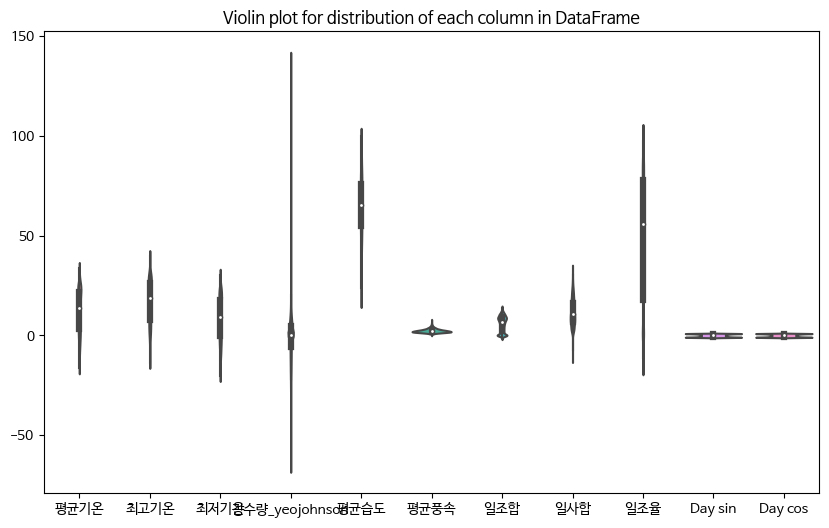

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn을 사용하여 violin plot 생성
plt.figure(figsize=(10,6))  # 그래프 크기 설정
sns.violinplot(data=train_cols_data)  # 데이터프레임을 seaborn violin plot 함수에 전달

# 그래프 제목 설정
plt.title('Violin plot for distribution of each column in DataFrame')

# 그래프 표시
plt.show()

In [ ]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(train_cols_data)
train_cols_scaled = scaler.transform(train_cols_data)
train_cols_data = train_cols_data.to_numpy()

In [ ]:
# split to train data and test data
def split_data(data_scaled, data, target_col=0, train_ratio=0.9):
    n_train = int(train_ratio * train_cols_scaled.shape[0])

    train_data_scaled = data_scaled[:n_train]
    test_data_scaled = data_scaled[n_train:]

    train_original = data[:n_train]
    test_original = data[n_train:]

    return train_data_scaled, test_data_scaled, train_original, test_original

In [ ]:
# data reformatting for LSTM
def reformat_data_for_lstm(data_scaled, seq_len, pred_days, target_index = 0):
    X, Y = [], []
    for i in range(seq_len, len(data_scaled)-pred_days +1):
        X.append(data_scaled[i - seq_len:i, :])
        Y.append(data_scaled[i + pred_days - 1:i + pred_days, target_index])
    return np.array(X), np.array(Y)

# reformatted X data for submission
def data_for_submission(data_scaled, seq_len, pred_days, target_index = 0):
    X = []
    for i in range(len(data_scaled)-pred_days, len(data_scaled)):
        X.append(data_scaled[i - seq_len:i, :])
    return np.array(X)

# Hyperparameter Tuning

In [ ]:
# LSTM model
def create_model(model_architecture, input_shape):
    model = Sequential()
    for i, layer in enumerate(model_architecture):
        if i == 0:
            model.add(LSTM(layer[1], input_shape=input_shape,
                           return_sequences=layer[2]))
        elif layer[0] == 0:
            model.add(LSTM(layer[1], return_sequences=layer[2]))
        elif layer[0] == 1:
            model.add(Dense(layer[1]))
    return model

In [ ]:
# Optimizer, Compile and Fit the model, Save model weights
def compile_and_fit(model, trainX, trainY, directory, iteration,
                    initial_learning_rate=0.001, decay_steps=1000,
                    decay_rate=0.96, staircase=True,
                    epochs=10, batch_size=32, validation_split=0.1):

    # Define the decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = initial_learning_rate,  # Initial learning rate
        decay_steps = decay_steps,                      # Decay step
        decay_rate = decay_rate,                        # Decay rate
        staircase = staircase                           # Whether to apply decay in a discrete staircase fashion
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Complile and Fit the model
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,
                        validation_split=validation_split, verbose=1)

    # Save model weights after training
    now = datetime.now() + timedelta(hours=9)
    now_date = f"{now.year}" + f"{now.month}".zfill(2) + f"{now.day}".zfill(2)
    now_time = f"{now.hour}".zfill(2) + f"{now.minute}".zfill(2)
    now_datetime = f"{now_date}_{now_time}"
    weight_name = f"lstm_{now_datetime}({iteration}).h5"
    model.save_weights(directory + 'save_weights/' + weight_name)

    return history, now_datetime

In [ ]:
# Prediction and inverse transform
def predict_and_inverse_transform(model, testX, scaler, target_index=0):
    prediction = model.predict(testX)

    mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)
    mean_values_pred[:, target_index] = np.squeeze(prediction)
    y_pred = scaler.inverse_transform(mean_values_pred)[:, target_index]

    return y_pred

In [ ]:
'''
model_architectures = [[(0,128,False), (1,trainY.shape[1])],
                       [(0,128,False), (1,32), (1,trainY.shape[1])],
                       [(0,128,False), (1,64), (1,trainY.shape[1])],
                       [(0,128,False), (1,32), (1,8), (1,trainY.shape[1])],

                       [(0,128,True), (0,64,False), (1,trainY.shape[1])],
                       [(0,128,True), (0,128,False), (1,trainY.shape[1])],
                       [(0,128,True), (0,128,False), (1,32), (1,trainY.shape[1])],
                       [(0,128,True), (0,128,False), (1,32), (1,8), (1,trainY.shape[1])],

                       [(0,128,True), (0,64,True), (0,32,False), (1,trainY.shape[1])],
                       [(0,128,True), (0,128,True), (0,64,False), (1,trainY.shape[1])],
                       [(0,128,True), (0,128,True), (0,128,False), (1,trainY.shape[1])],
                       [(0,128,True), (0,128,True), (0,128,False), (1,32), (1,trainY.shape[1])],
                       [(0,128,True), (0,128,True), (0,128,False), (1,32), (1,8), (1,trainY.shape[1])],

                       [(0,128,True), (0,128,True), (0,128,True), (0,128,False), (1,trainY.shape[1])]]
'''

model_architectures = [[(0,128,False), (1,1)],
                       [(0,128,False), (1,32), (1,1)],
                       [(0,128,False), (1,64), (1,1)],
                       [(0,128,False), (1,32), (1,8), (1,1)]]

Epoch 1/2
542/542 [==============================] - 22s 38ms/step - loss: 0.1058 - val_loss: 0.1013
Epoch 2/2
542/542 [==============================] - 20s 37ms/step - loss: 0.0965 - val_loss: 0.0908


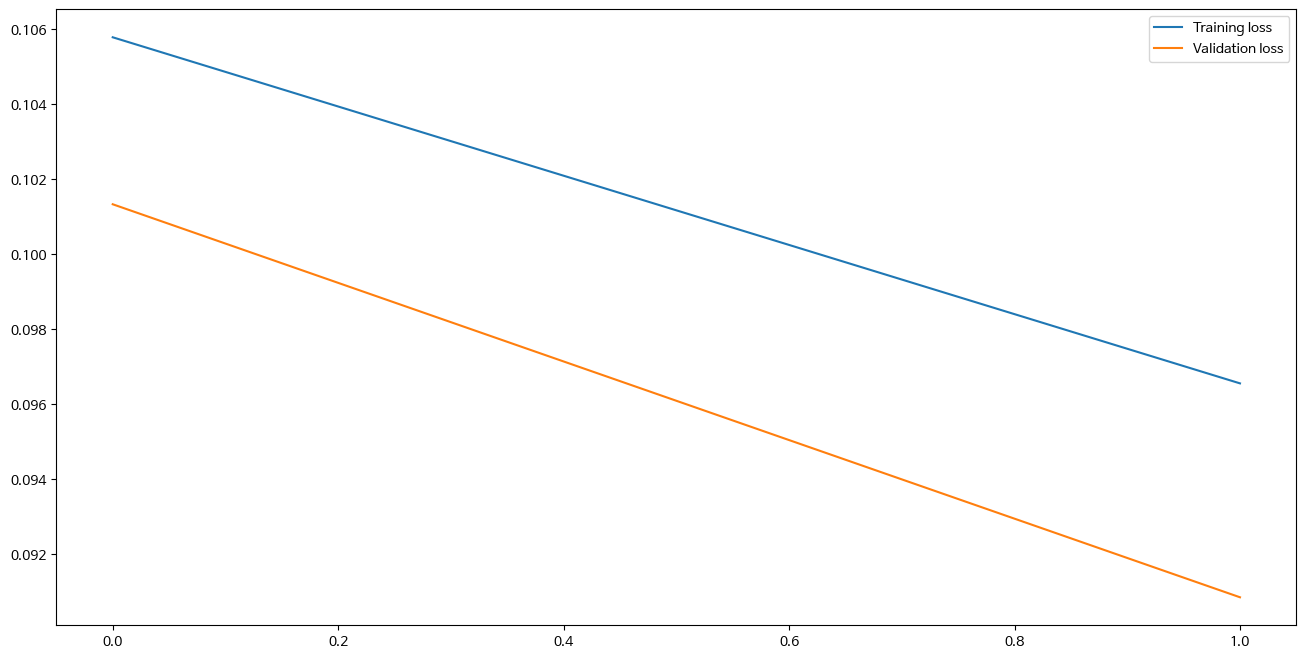

27/27 [==============================] - 1s 17ms/step
testY_pred.shape = (843,)
12/12 [==============================] - 0s 15ms/step
submitY_pred.shape = (365,)
Epoch 1/2
542/542 [==============================] - 23s 38ms/step - loss: 0.1061 - val_loss: 0.1056
Epoch 2/2
542/542 [==============================] - 20s 36ms/step - loss: 0.0975 - val_loss: 0.0918


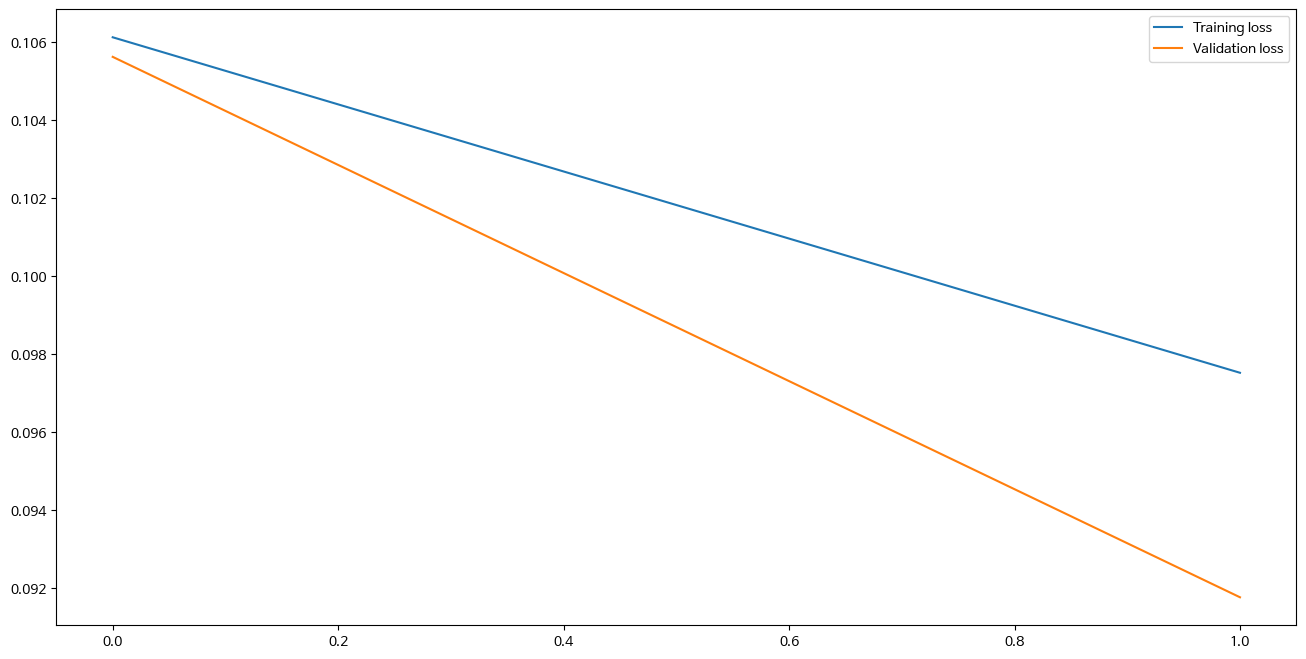

27/27 [==============================] - 1s 16ms/step
testY_pred.shape = (843,)
12/12 [==============================] - 0s 15ms/step
submitY_pred.shape = (365,)
Epoch 1/2
542/542 [==============================] - 23s 38ms/step - loss: 0.1044 - val_loss: 0.1031
Epoch 2/2
542/542 [==============================] - 20s 36ms/step - loss: 0.0978 - val_loss: 0.0927


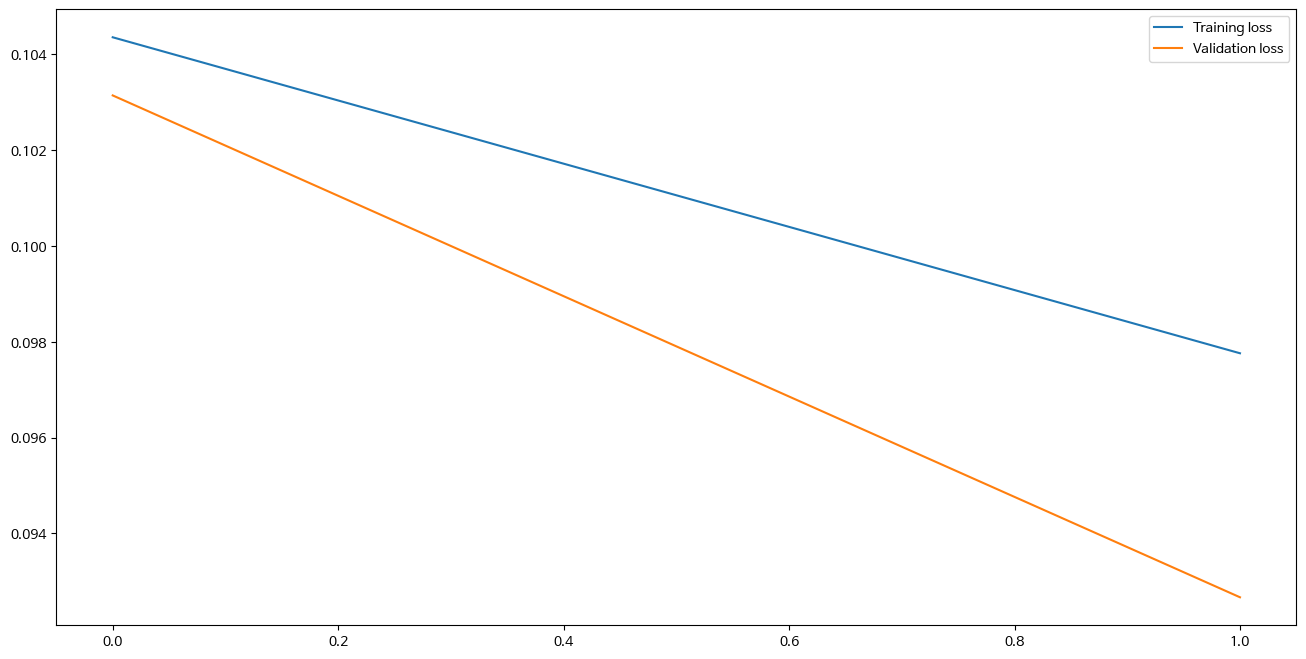

27/27 [==============================] - 1s 15ms/step
testY_pred.shape = (843,)
12/12 [==============================] - 0s 15ms/step
submitY_pred.shape = (365,)
Epoch 1/2
542/542 [==============================] - 24s 38ms/step - loss: 0.1057 - val_loss: 0.1050
Epoch 2/2
542/542 [==============================] - 20s 37ms/step - loss: 0.0978 - val_loss: 0.0917


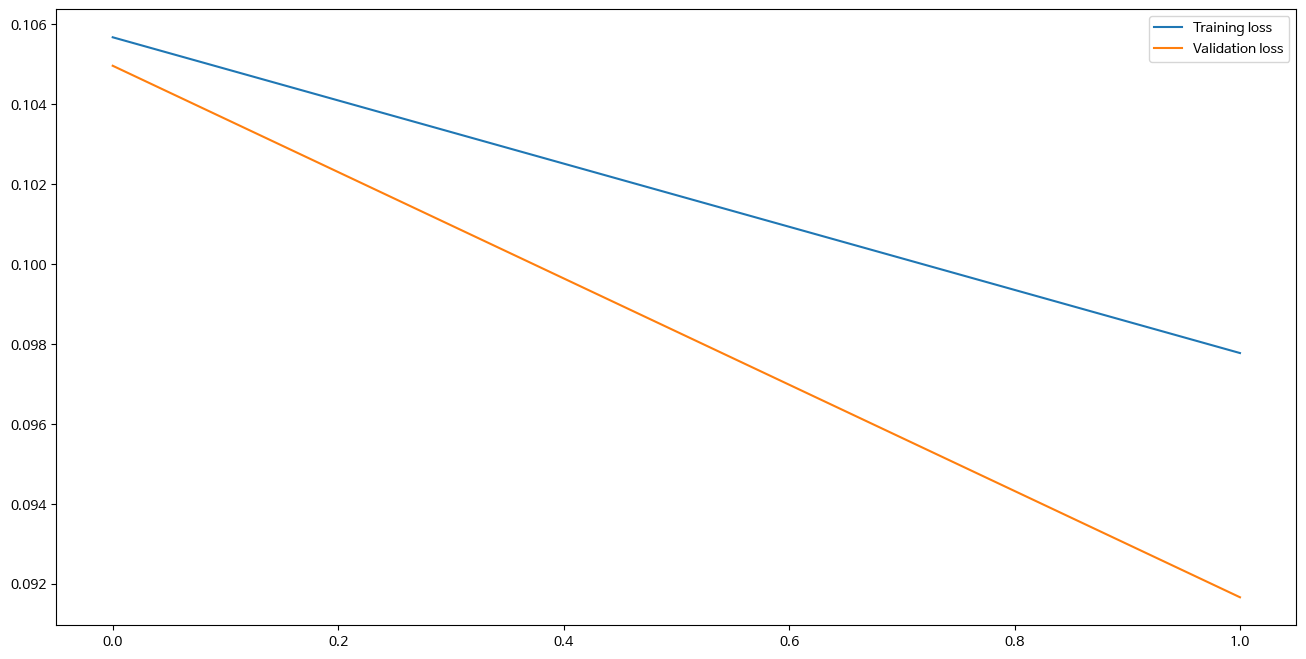

27/27 [==============================] - 1s 15ms/step
testY_pred.shape = (843,)
12/12 [==============================] - 0s 15ms/step
submitY_pred.shape = (365,)


In [ ]:
losses = []
val_losses = []
for i, model_architecture in enumerate(model_architectures):
    # Split data
    train_data_scaled, test_data_scaled, train_original, test_original = split_data(
        train_cols_scaled, train_cols_data, train_ratio=0.9)

    # Reformat data for LSTM
    trainX, trainY = reformat_data_for_lstm(
        train_data_scaled, seq_len=3*365, pred_days=365)
    testX, testY = reformat_data_for_lstm(
        test_data_scaled, seq_len=3*365, pred_days=365)
    trainX_org, trainY_org = reformat_data_for_lstm(
        train_original, seq_len=3*365, pred_days=365)
    testX_org, testY_org = reformat_data_for_lstm(
        test_original, seq_len=3*365, pred_days=365)
    submitX = data_for_submission(
        train_cols_scaled, seq_len=3*365, pred_days=365)

    # Create model
    model = create_model(model_architecture, (trainX.shape[1], trainX.shape[2]))

    # Compile and fit model
    history, now_datetime = compile_and_fit(model, trainX, trainY, directory, i,
                                           initial_learning_rate=0.001, decay_steps=1000,
                                           decay_rate=0.96, staircase=True,
                                           epochs=2, batch_size=32, validation_split=0.1)

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

    # Save losses of the model
    losses.append([i, now_datetime, history.history['loss'][-1]])
    val_losses.append([i, now_datetime, history.history['val_loss'][-1]])

    # Predict and inverse transform
    testY_pred = predict_and_inverse_transform(model, testX, scaler)
    print(f"testY_pred.shape = {testY_pred.shape}")
    submitY_pred = predict_and_inverse_transform(model, submitX, scaler)
    print(f"submitY_pred.shape = {submitY_pred.shape}")

    # Saving the submission prediction
    df_submission = pd.read_csv(sample_dir)
    df_submission.iloc[:, 1] = submitY_pred[:df_submission.shape[0]]

    submission_name = f"submission_{now_datetime}({i}).csv"
    df_submission.to_csv(directory + 'submissions/' + submission_name, index=False)

# Experiment

In [ ]:
print(losses)
print(val_losses)

[[0, '20231229_0016', 0.09654805809259415], [1, '20231229_0017', 0.09751828759908676], [2, '20231229_0018', 0.09776093065738678], [3, '20231229_0019', 0.09777195006608963]]
[[0, '20231229_0016', 0.0908443033695221], [1, '20231229_0017', 0.09176044166088104], [2, '20231229_0018', 0.0926688089966774], [3, '20231229_0019', 0.09166178107261658]]


In [ ]:
print(f"testY_pred.shape = {testY_pred.shape}")
print(f"testY_org.shape = {testY_org.shape}")
testY_org = np.squeeze(testY_org, axis=1)
print(f"testY_org.shape = {testY_org.shape}")

testY_pred.shape = (843,)
testY_org.shape = (843, 1)
testY_org.shape = (843,)


In [ ]:
print(type(testY_pred))
print(type(testY_org))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
combined = pd.concat([pd.Series(testY_pred), pd.Series(testY_org)], axis=1)
combined.columns = ["prediction", "actual"]

In [ ]:
combined

,prediction,actual
0,23.228494,22.8
1,22.745229,22.4
2,22.495883,20.2
3,22.380854,21.5
4,22.295611,21.3
...,...,...
838,-2.216574,-2.6
839,-1.975364,-3.3
840,-2.103139,-2.9
841,-2.647677,-1.8


In [ ]:
combined["diff"] = (combined["actual"] - combined["prediction"]).abs()

<Axes: >

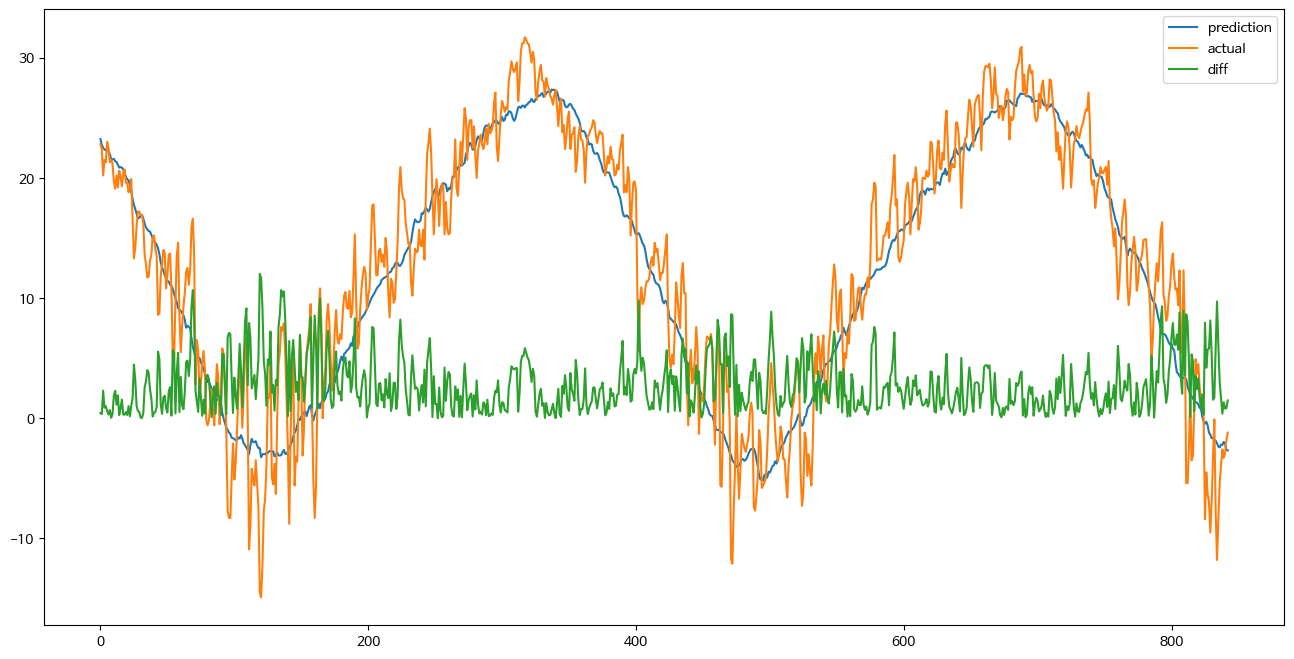

In [ ]:
combined.plot()

In [ ]:
mean_absolute_error(testY_pred, testY_org)

2.730980289390303